In [1]:
import pandas as pd
import numpy as np
#from utils_c import *
#from utils_metrics_FPx import *
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.interactive import selectItemsInteractive


from import_datasets import *
ITEMSETS=["support", "itemsets", "tn", "tp", "fn", "fp"]
ADDIT_DIVER_METRICS=["d_fpr","d_fpr_abs", "d_fnr", "d_fnr_abs", "d_accuracy", "SPsf", "FPsf","FNsf","ACsf"] 
DIVERGENCE_METRICS=["d_fpr", "d_fnr", "d_accuracy"] 
CLASSIFICATION_METRICS=["fpr", "fnr", "accuracy"]
T_VALUES=["t_value_fp", "t_value_fn", "t_value_tp_tn"]
INFOS=ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS+T_VALUES
EFF_LOSS=["effect_size", "log_loss"]
pd.set_option('display.max_colwidth', -1)

/var/folders/1t/9km2pgcx2_54jq76qsqtpqlr0000gp/T/ipykernel_11359/1039306412.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Dataset 

In [2]:
abbreviations={"marital-status":"status", "High School grad":"HS", "education":"edu", \
               "relationship":"relation", "occupation":"occup", "hours-per-week":"hoursXW",\
               "workclass":"workcl", "Never-Married":"Unmarried",\
               "=<=":"≤",\
              "Self-emp-not-inc":"self-not-inc", "Female":"F", "Male":"M", "capital-":"", "Professional":"Prof"}
dataset_name="adult"

In [3]:
if dataset_name=="compas":
    dfI, class_map =import_process_compas(risk_class=risk_class_type)
    dfI.reset_index(drop=True, inplace=True)
    display(dfI.head(3))
elif dataset_name=="heart":
    dfI, class_map=import_process_heart()
    display(dfI.head(3))
elif dataset_name=="bank":
    dfI, class_map=import_process_bank()
    display(dfI.head(3))
elif dataset_name=="adult":
    dfI, class_map=import_process_adult()
    display(dfI.head(3))
elif dataset_name=="german":
    dfI, class_map=import_process_german()
    display(dfI.head(3))

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,class
0,25,Private,Dropout,Never-Married,Blue-Collar,Own-child,Black,Male,0,0,40,<=50K
1,38,Private,High School grad,Married,Blue-Collar,Husband,White,Male,0,0,50,<=50K
2,28,Local-gov,Associates,Married,Other,Husband,White,Male,0,0,40,>50K


In [4]:
print(f"Number of instances: {len(dfI)}, number of features: {len(dfI.columns)-1}")

Number of instances: 45222, number of features: 11


## Train and predict

In [5]:
type_cl="RF"
labelEncoding=True

X_FP, y_FP, y_predicted, y_predict_prob, encoders, indexes_FP=train_predict(dfI, type_cl=type_cl, labelEncoding=labelEncoding, validation="cv")
attributes=dfI.columns.drop("class")
X_discretized=discretize(dfI, attributes=attributes, indexes_FP=indexes_FP, dataset_name=dataset_name)

print("X")
display(X_FP.head())
print("y")
display(y_FP.head())
print("X_discretized")
display(X_discretized.head())

X


/Users/eliana/anaconda3/envs/divexplorerp/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,25,2,3,1,1,3,2,1,0,0,40
1,38,2,4,0,1,0,4,1,0,0,50
2,28,1,0,0,3,0,4,1,0,0,40
3,44,2,4,0,1,0,2,1,7688,0,40
4,34,2,3,1,6,1,4,1,0,0,30


y


,class
0,<=50K
1,<=50K
2,>50K
3,>50K
4,<=50K


X_discretized


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,<=28,Private,Dropout,Never-Married,Blue-Collar,Own-child,Black,Male,0,0,<=40
1,(37-47],Private,High School grad,Married,Blue-Collar,Husband,White,Male,0,0,>45
2,<=28,Local-gov,Associates,Married,Other,Husband,White,Male,0,0,<=40
3,(37-47],Private,High School grad,Married,Blue-Collar,Husband,Black,Male,High,0,<=40
4,(28-37],Private,Dropout,Never-Married,Service,Not-in-family,White,Male,0,0,<=40


In [6]:
from collections import Counter
print("True Class: ", Counter(y_FP["class"]))
print("Predicted class:", Counter(y_predicted))

from sklearn.metrics import accuracy_score
print("Accuracy: ", round(accuracy_score(y_FP, y_predicted),5))

True Class:  Counter({'<=50K': 34014, '>50K': 11208})
Predicted class: Counter({'<=50K': 35543, '>50K': 9679})
Accuracy:  0.84868


In [7]:
X_discretized["class"]=y_FP["class"]
X_discretized["predicted"]=y_predicted

In [8]:
X_discretized.to_csv("adult_discretized_RF.csv", index=False)

# Extract divergence

In [9]:
# Input: 
# discretized dataframe
# true class
# predicted class  (opt)

# If input just one class --> positive rate and negative rate

True class and predicted class (column names as parameters)

In [10]:
min_sup=0.05

fp_diver=FP_DivergenceExplorer(X_discretized, true_class_name="class", predicted_class_name="predicted", class_map=class_map, dataset_name=dataset_name)
FP_fm=fp_diver.getFrequentPatternDivergence(min_support=min_sup)

In [11]:
print(f"Number of frequent patterns: {len(FP_fm)}")

Number of frequent patterns: 4535


In [12]:
FP_fm.sort_values("support", ascending=False)[["support_count"]+INFOS].head(5)

,support_count,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy,t_value_fp,t_value_fn,t_value_tp_tn
0,45222.0,1.000000,(),31357.0,7022.0,4186.0,2657.0,0.078115,0.373483,0.848680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,43082.0,0.952678,(capital-loss=0),30391.0,6031.0,4079.0,2581.0,0.078279,0.403462,0.845411,0.000164,0.029979,-0.003269,0.079232,4.484828,1.349021
2,41432.0,0.916191,(capital-gain=0),30012.0,4761.0,4072.0,2587.0,0.079358,0.460999,0.839279,0.001243,0.087515,-0.009401,0.595997,12.501044,3.808127
3,39292.0,0.868869,"(capital-loss=0, capital-gain=0)",29046.0,3770.0,3965.0,2511.0,0.079570,0.512605,0.835183,0.001455,0.139122,-0.013497,0.691663,19.077554,5.359680
4,38903.0,0.860267,(race=White),26280.0,6423.0,3784.0,2416.0,0.084193,0.370726,0.840629,0.006078,-0.002757,-0.008051,2.774662,0.416575,3.212436


# Divergence

In [13]:
saveFig=False
outDirShap="./results/figures/shap"
outDirLattice="./results/figures/lattice"

if saveFig:
    createDir(outDirShap)
    createDir(outDirLattice)

In [14]:
from divexplorer.FP_Divergence import FP_Divergence,abbreviateDict

## FPR

In [15]:
fp_divergence_fpr=FP_Divergence(FP_fm, "d_fpr")

In [16]:
fp_divergence_fpr.getInfoItemset(frozenset())[ITEMSETS+CLASSIFICATION_METRICS]

,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy
0,1.0,(),31357.0,7022.0,4186.0,2657.0,0.078115,0.373483,0.84868


### Top FPR

In [17]:
fp_divergence_fpr.getDivergence(th_redundancy=0)[ITEMSETS+DIVERGENCE_METRICS].head(10)

,support,itemsets,tn,tp,fn,fp,d_fpr,d_fnr,d_accuracy
4431,0.050927,"(race=White, occupation=Professional, marital-status=Married, capital-gain=0)",321.0,1240.0,312.0,430.0,0.494455,-0.172452,-0.170868
4499,0.050307,"(occupation=Professional, capital-loss=0, marital-status=Married, capital-gain=0)",362.0,1102.0,347.0,464.0,0.483628,-0.134008,-0.205163
3789,0.056654,"(occupation=Professional, marital-status=Married, capital-gain=0)",380.0,1354.0,349.0,479.0,0.479510,-0.168551,-0.171865
3514,0.059661,"(race=White, education=Bachelors, capital-gain=0, marital-status=Married, capital-loss=0)",454.0,1241.0,432.0,571.0,0.478958,-0.115264,-0.220437
3858,0.055858,"(race=White, occupation=Professional, capital-loss=0, marital-status=Married)",342.0,1448.0,315.0,421.0,0.473654,-0.194811,-0.140050
4187,0.052828,"(race=White, education=Bachelors, capital-gain=0, relationship=Husband, capital-loss=0)",409.0,1103.0,376.0,501.0,0.472435,-0.119257,-0.215779
3005,0.066251,"(race=White, education=Bachelors, capital-gain=0, marital-status=Married)",476.0,1505.0,435.0,580.0,0.471128,-0.149256,-0.187465
3350,0.061674,"(race=White, occupation=Professional, marital-status=Married)",357.0,1680.0,317.0,435.0,0.471128,-0.214745,-0.118311
3040,0.065742,"(education=Bachelors, capital-gain=0, capital-loss=0, marital-status=Married)",517.0,1356.0,473.0,627.0,0.469962,-0.114872,-0.218676
4131,0.053293,"(race=White, education=Bachelors, capital-gain=0, sex=Male, marital-status=Married, capital-loss=0)",418.0,1104.0,382.0,506.0,0.469504,-0.116417,-0.217145


Top FPR - Only divergence info

In [18]:
fp_divergence_fpr.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_fpr.metric, fp_divergence_fpr.t_value_col]].head(5)

,support,itemsets,d_fpr,t_value_fp
4431,0.050927,"(race=White, occupation=Professional, marital-status=Married, capital-gain=0)",0.494455,27.342474
4499,0.050307,"(occupation=Professional, capital-loss=0, marital-status=Married, capital-gain=0)",0.483628,27.953786
3789,0.056654,"(occupation=Professional, marital-status=Married, capital-gain=0)",0.479510,28.231050
3514,0.059661,"(race=White, education=Bachelors, capital-gain=0, marital-status=Married, capital-loss=0)",0.478958,30.770206
3858,0.055858,"(race=White, occupation=Professional, capital-loss=0, marital-status=Married)",0.473654,26.264421


Threshold on redundancy

In [19]:
fp_divergence_fpr.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_fpr.metric, fp_divergence_fpr.t_value_col]].head(5)

,support,itemsets,d_fpr,t_value_fp
4431,0.050927,"(race=White, occupation=Professional, marital-status=Married, capital-gain=0)",0.494455,27.342474
4499,0.050307,"(occupation=Professional, capital-loss=0, marital-status=Married, capital-gain=0)",0.483628,27.953786
3789,0.056654,"(occupation=Professional, marital-status=Married, capital-gain=0)",0.479510,28.231050
3514,0.059661,"(race=White, education=Bachelors, capital-gain=0, marital-status=Married, capital-loss=0)",0.478958,30.770206
3858,0.055858,"(race=White, occupation=Professional, capital-loss=0, marital-status=Married)",0.473654,26.264421


Printable - threshold on redundancy

In [20]:
th_redundancy=0.01
div_fpr=fp_divergence_fpr.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_fpr.metric, fp_divergence_fpr.t_value_col]]
print(f"{dataset_name} - #FP: {len(div_fpr)-1} - {fp_divergence_fpr.metric_name} - th_redundancy: {th_redundancy}")
display(div_fpr.head(5))

adult - #FP: 198 - FPR - th_redundancy: 0.01


,support,itemsets,d_fpr,t_value_fp
4431,0.050927,"(race=White, occupation=Professional, marital-status=Married, capital-gain=0)",0.494455,27.342474
3789,0.056654,"(occupation=Professional, marital-status=Married, capital-gain=0)",0.479510,28.231050
3005,0.066251,"(race=White, education=Bachelors, capital-gain=0, marital-status=Married)",0.471128,30.666076
3350,0.061674,"(race=White, occupation=Professional, marital-status=Married)",0.471128,26.598005
3714,0.057583,"(education=Bachelors, capital-loss=0, capital-gain=0, relationship=Husband)",0.466430,29.513293


In [21]:
fp_divergence_fpr.getDivergenceTopKDf(K=10, th_redundancy=0)

,itemsets,d_fpr
4431,"(race=White, occupation=Professional, marital-status=Married, capital-gain=0)",0.494455
4499,"(occupation=Professional, capital-loss=0, marital-status=Married, capital-gain=0)",0.483628
3789,"(occupation=Professional, marital-status=Married, capital-gain=0)",0.479510
3514,"(race=White, education=Bachelors, capital-gain=0, marital-status=Married, capital-loss=0)",0.478958
3858,"(race=White, occupation=Professional, capital-loss=0, marital-status=Married)",0.473654
4187,"(race=White, education=Bachelors, capital-gain=0, relationship=Husband, capital-loss=0)",0.472435
3005,"(race=White, education=Bachelors, capital-gain=0, marital-status=Married)",0.471128
3350,"(race=White, occupation=Professional, marital-status=Married)",0.471128
3040,"(education=Bachelors, capital-gain=0, capital-loss=0, marital-status=Married)",0.469962
4131,"(race=White, education=Bachelors, capital-gain=0, sex=Male, marital-status=Married, capital-loss=0)",0.469504


### Shapley value of TOP-K patterns

In [22]:
fp_divergence_ofI=fp_divergence_fpr
topK_fpr=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
topK_fpr

{frozenset({'capital-gain=0',
            'marital-status=Married',
            'occupation=Professional',
            'race=White'}): 0.4944550129237143,
 frozenset({'capital-gain=0',
            'capital-loss=0',
            'marital-status=Married',
            'occupation=Professional'}): 0.4836284475371272,
 frozenset({'capital-gain=0',
            'marital-status=Married',
            'occupation=Professional'}): 0.47951025165081307,
 frozenset({'capital-gain=0',
            'capital-loss=0',
            'education=Bachelors',
            'marital-status=Married',
            'race=White'}): 0.47895827686447623,
 frozenset({'capital-loss=0',
            'marital-status=Married',
            'occupation=Professional',
            'race=White'}): 0.47365443771861426}

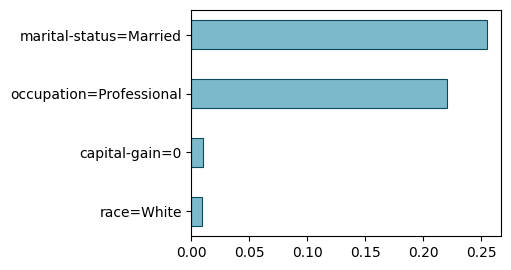

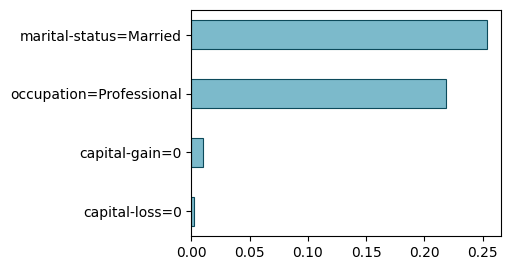

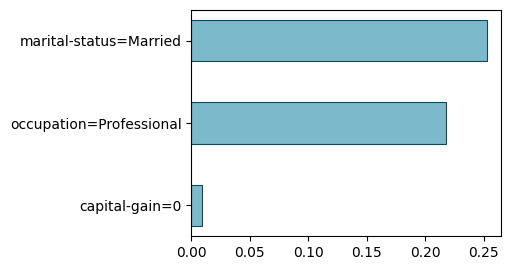

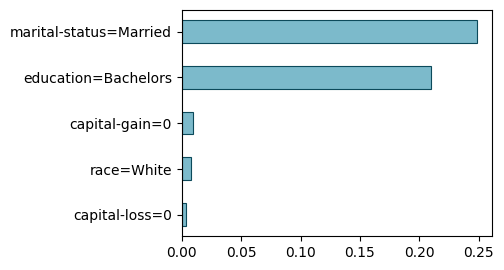

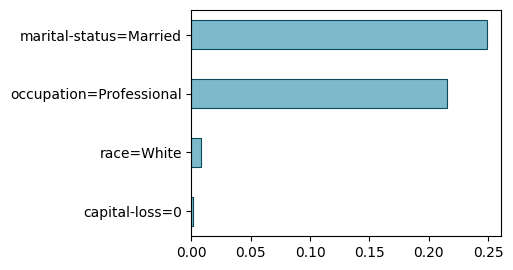

In [23]:
fp_divergence_ofI=fp_divergence_fpr
topK_fpr=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_fpr.keys():
    fp_divergence_ofI.plotShapleyValue(item)

{frozenset({'race=White', 'occupation=Professional', 'marital-status=Married', 'capital-gain=0'}): 0.4944550129237143}
{frozenset({'race=White'}): 0.008792004331707338, frozenset({'occupation=Professional'}): 0.22079957925542815, frozenset({'marital-status=Married'}): 0.2547157211538788, frozenset({'capital-gain=0'}): 0.010147708182699998}


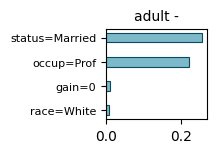

In [24]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_fpr.metric_name}_{min_sup}"
itemset_div=fp_divergence_fpr.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_fpr.computeShapleyValue(list(itemset_div.keys())[0])
print(itemset_shap)
fp_divergence_fpr.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=False, nameFig=outputName)

#### Lattice Explorer

In [25]:
top1=list(fp_divergence_fpr.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_fpr.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small", getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [26]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_fpr.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,corr_factor
2735,(occupation=Blue-Collar),"(marital-status=Married, age=(37-47])","(occupation=Blue-Collar, marital-status=Married, age=(37-47])",-0.028955,0.203135,0.047618,13.134172,0.155517
7794,(occupation=Blue-Collar),"(sex=Male, marital-status=Married, age=(37-47])","(sex=Male, occupation=Blue-Collar, marital-status=Married, age=(37-47])",-0.028955,0.196643,0.044952,12.491075,0.151691
8543,(occupation=Blue-Collar),"(race=White, capital-loss=0, marital-status=Married, capital-gain=0)","(race=White, capital-gain=0, occupation=Blue-Collar, marital-status=Married, capital-loss=0)",-0.028955,0.144549,0.020982,20.318522,0.123567
3639,(occupation=Blue-Collar),"(race=White, marital-status=Married, capital-gain=0)","(race=White, capital-gain=0, occupation=Blue-Collar, marital-status=Married)",-0.028955,0.141943,0.019948,20.521695,0.121996
14216,(occupation=Blue-Collar),"(race=White, capital-gain=0, relationship=Husband, sex=Male, capital-loss=0)","(race=White, capital-gain=0, relationship=Husband, sex=Male, occupation=Blue-Collar, capital-loss=0)",-0.028955,0.141681,0.021288,19.094998,0.120393


Details of $S$ and $S \cup i$ for the top corrective items

In [27]:
d=fp_divergence_fpr.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_fpr.getInfoItemsets([S,S_i])[ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS])

,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
761,0.143536,"(marital-status=Married, age=(37-47])",2139.0,2494.0,1021.0,837.0,0.281250,0.290469,0.713758,0.203135,-0.083014,-0.134922
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",1342.0,332.0,480.0,193.0,0.125733,0.591133,0.713251,0.047618,0.217650,-0.135429


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
943,0.128588,"(sex=Male, marital-status=Married, age=(37-47])",1948.0,2219.0,910.0,738.0,0.274758,0.290828,0.716595,0.196643,-0.082655,-0.132085
4513,0.050197,"(sex=Male, occupation=Blue-Collar, marital-status=Married, age=(37-47])",1304.0,324.0,459.0,183.0,0.123067,0.586207,0.717181,0.044952,0.212724,-0.131499


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
106,0.341670,"(race=White, capital-gain=0, capital-loss=0, marital-status=Married)",7237.0,3320.0,2821.0,2073.0,0.222664,0.459371,0.683257,0.144549,0.085888,-0.165423
771,0.142187,"(race=White, capital-gain=0, occupation=Blue-Collar, marital-status=Married, capital-loss=0)",4391.0,302.0,1254.0,483.0,0.099097,0.805913,0.729860,0.020982,0.432429,-0.118820


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
87,0.368714,"(race=White, capital-gain=0, marital-status=Married)",7528.0,4166.0,2856.0,2124.0,0.220058,0.406722,0.701331,0.141943,0.033239,-0.147348
688,0.149794,"(race=White, capital-gain=0, occupation=Blue-Collar, marital-status=Married)",4562.0,439.0,1277.0,496.0,0.098062,0.744172,0.738264,0.019948,0.370689,-0.110416


#### Plot Shapley comparison corrective

In [28]:
from divexplorer.shapley_value_FPx import plotComparisonShapleyValues, compareShapleyValues, normalizeMax

,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
761,0.143536,"(marital-status=Married, age=(37-47])",2139.0,2494.0,1021.0,837.0,0.281250,0.290469,0.713758,0.203135,-0.083014,-0.134922
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",1342.0,332.0,480.0,193.0,0.125733,0.591133,0.713251,0.047618,0.217650,-0.135429


∇FPR(S):0.203 -->  ∇FPR(S U i):0.048


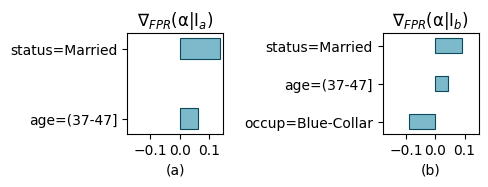

In [29]:
id_col=0
fp_divergence_ofI=fp_divergence_fpr
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" 
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=False, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [30]:
id_col=0
fp_divergence_ofI=fp_divergence_fpr
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

frozenset({'occupation=Blue-Collar', 'marital-status=Married', 'age=(37-47]'})


## For interactive analysis

In [31]:
selectItemsInteractive(fp_divergence_fpr)

Button(description='Select items', style=ButtonStyle())

## FNR

In [32]:
fp_divergence_fnr=FP_Divergence(FP_fm, "d_fnr")

### Top FNR

In [33]:
fp_divergence_fnr.getDivergence(th_redundancy=0)[ITEMSETS+DIVERGENCE_METRICS].head(10)

,support,itemsets,tn,tp,fn,fp,d_fpr,d_fnr,d_accuracy
597,0.162310,"(capital-gain=0, age=<=28, marital-status=Never-Married, capital-loss=0, hours-per-week=<=40)",7305.0,0.0,28.0,7.0,-0.077158,0.626517,0.146552
777,0.141635,"(capital-gain=0, marital-status=Never-Married, education=High School grad, capital-loss=0, hours-per-week=<=40)",6351.0,0.0,46.0,8.0,-0.076857,0.626517,0.142889
1014,0.124718,"(hours-per-week=<=40, capital-gain=0, relationship=Own-child, capital-loss=0)",5595.0,0.0,36.0,9.0,-0.076509,0.626517,0.143341
1037,0.123347,"(capital-loss=0, capital-gain=0, relationship=Own-child, marital-status=Never-Married)",5543.0,0.0,30.0,5.0,-0.077214,0.626517,0.145046
1217,0.114391,"(capital-gain=0, age=<=28, marital-status=Never-Married, education=High School grad, capital-loss=0)",5156.0,0.0,14.0,3.0,-0.077533,0.626517,0.148034
1226,0.114126,"(hours-per-week=<=40, capital-gain=0, relationship=Own-child, marital-status=Never-Married)",5130.0,0.0,27.0,4.0,-0.077336,0.626517,0.145314
1331,0.109438,"(capital-gain=0, relationship=Own-child, age=<=28)",4926.0,0.0,19.0,4.0,-0.077304,0.626517,0.146673
1373,0.107713,"(capital-gain=0, relationship=Own-child, marital-status=Never-Married, workclass=Private)",4839.0,0.0,28.0,4.0,-0.077289,0.626517,0.144751
1794,0.092234,"(race=White, capital-gain=0, age=<=28, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",4100.0,0.0,60.0,11.0,-0.075439,0.626517,0.134298
1917,0.088231,"(education=High School grad, capital-gain=0, capital-loss=0, relationship=Own-child)",3956.0,0.0,28.0,6.0,-0.076601,0.626517,0.142799


Top FPR - Only divergence info

In [34]:
div_fnr=fp_divergence_fnr.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_fnr.metric, fp_divergence_fnr.t_value_col]]
div_fnr.head(10)

,support,itemsets,d_fnr,t_value_fn
597,0.162310,"(capital-gain=0, age=<=28, marital-status=Never-Married, capital-loss=0, hours-per-week=<=40)",0.626517,18.216224
777,0.141635,"(capital-gain=0, marital-status=Never-Married, education=High School grad, capital-loss=0, hours-per-week=<=40)",0.626517,28.966569
1014,0.124718,"(hours-per-week=<=40, capital-gain=0, relationship=Own-child, capital-loss=0)",0.626517,23.051767
1037,0.123347,"(capital-loss=0, capital-gain=0, relationship=Own-child, marital-status=Never-Married)",0.626517,19.432831
1217,0.114391,"(capital-gain=0, age=<=28, marital-status=Never-Married, education=High School grad, capital-loss=0)",0.626517,9.577726
1226,0.114126,"(hours-per-week=<=40, capital-gain=0, relationship=Own-child, marital-status=Never-Married)",0.626517,17.606120
1331,0.109438,"(capital-gain=0, relationship=Own-child, age=<=28)",0.626517,12.685657
1373,0.107713,"(capital-gain=0, relationship=Own-child, marital-status=Never-Married, workclass=Private)",0.626517,18.216224
1794,0.092234,"(race=White, capital-gain=0, age=<=28, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",0.626517,36.957271
1917,0.088231,"(education=High School grad, capital-gain=0, capital-loss=0, relationship=Own-child)",0.626517,18.216224


Threshold on redundancy

In [35]:
th_redundancy=0.05
div_fnr=fp_divergence_fnr.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_fnr.metric, fp_divergence_fnr.t_value_col]]
display(div_fnr.head(5))
print(f"{dataset_name} - #FP {len(div_fnr)-1} - {fp_divergence_fnr.metric_name} - th_redundancy: {th_redundancy}")

,support,itemsets,d_fnr,t_value_fn
1331,0.109438,"(capital-gain=0, relationship=Own-child, age=<=28)",0.626517,12.685657
3353,0.061651,"(capital-gain=0, age=<=28, sex=Female, education=High School grad, capital-loss=0)",0.626517,15.768945
4408,0.051037,"(education=High School grad, sex=Male, capital-gain=0, relationship=Own-child)",0.626517,12.685657
2475,0.075118,"(sex=Female, relationship=Unmarried, capital-loss=0, capital-gain=0)",0.616808,43.262962
3497,0.059904,"(education=High School grad, relationship=Unmarried, capital-loss=0, capital-gain=0)",0.610644,27.399339


adult - #FP 168 - FNR - th_redundancy: 0.05


### Shapley value of TOP-K patterns

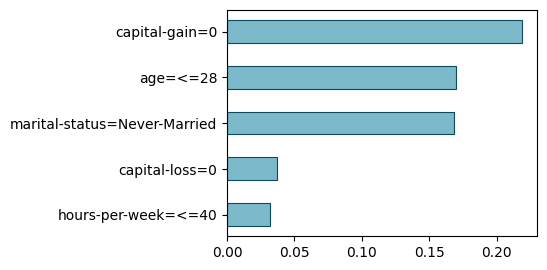

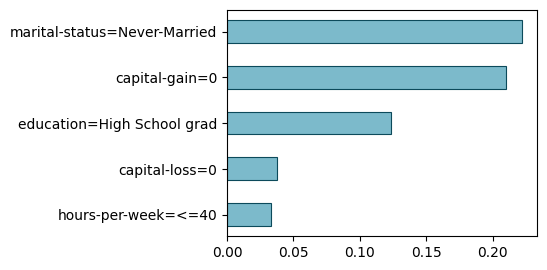

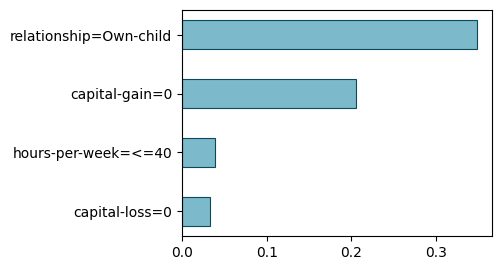

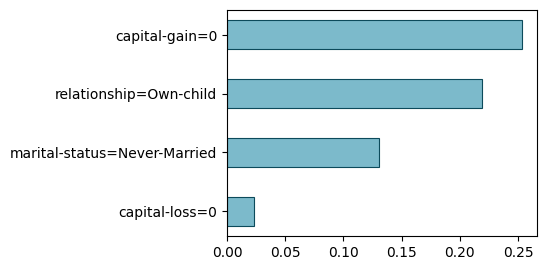

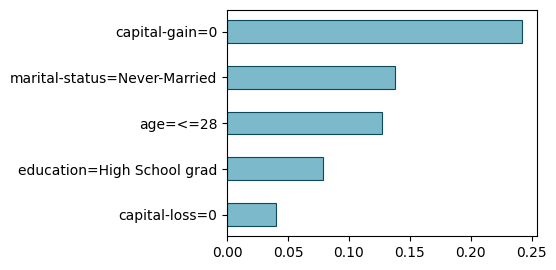

In [36]:
fp_divergence_ofI=fp_divergence_fnr
topK_fnr=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_fnr.keys():
    fp_divergence_ofI.plotShapleyValue(itemset=item)

{frozenset({'capital-gain=0', 'age=<=28', 'marital-status=Never-Married', 'capital-loss=0', 'hours-per-week=<=40'}): 0.6265167737330478}


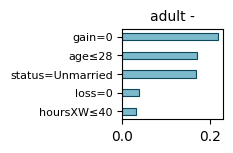

In [37]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_fnr.metric_name}_{min_sup}"
itemset_div=fp_divergence_fnr.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_fnr.computeShapleyValue(list(itemset_div.keys())[0])
fp_divergence_fnr.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=saveFig, nameFig=outputName)

#### Lattice Explorer

In [38]:
top1=list(fp_divergence_fnr.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_fnr.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small")#, getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [39]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_fnr.getCorrectiveItems()
corrSign.head(10)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,corr_factor
15107,(marital-status=Never-Married),"(age=<=28, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)","(age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",0.212822,0.414752,0.055088,2.066083,0.359664
9947,(marital-status=Never-Married),"(education=High School grad, hours-per-week=<=40, age=<=28, workclass=Private)","(age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, hours-per-week=<=40)",0.212822,0.357700,0.001517,2.111255,0.356183
15666,(marital-status=Never-Married),"(race=White, age=<=28, workclass=Private, education=High School grad, hours-per-week=<=40)","(race=White, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, hours-per-week=<=40)",0.212822,0.409649,0.055088,2.031604,0.354561
7437,(education=High School grad),"(sex=Female, age=<=28, marital-status=Never-Married)","(education=High School grad, sex=Female, age=<=28, marital-status=Never-Married)",0.163739,0.336194,-0.040150,2.087595,0.296044
13432,(marital-status=Never-Married),"(education=High School grad, sex=Female, capital-loss=0, age=<=28)","(age=<=28, marital-status=Never-Married, sex=Female, education=High School grad, capital-loss=0)",0.212822,0.329219,-0.040150,2.095141,0.289070
15222,(marital-status=Never-Married),"(race=White, age=<=28, workclass=Private, education=High School grad, capital-loss=0)","(race=White, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0)",0.212822,0.411702,0.126517,2.100105,0.285185
10083,(marital-status=Never-Married),"(race=White, education=High School grad, age=<=28, workclass=Private)","(race=White, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad)",0.212822,0.359393,0.088055,2.024808,0.271338
9472,(marital-status=Never-Married),"(education=High School grad, capital-loss=0, age=<=28, workclass=Private)","(age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0)",0.212822,0.386791,0.126517,2.033575,0.260274
9703,(marital-status=Never-Married),"(race=White, education=High School grad, capital-loss=0, age=<=28)","(race=White, age=<=28, marital-status=Never-Married, education=High School grad, capital-loss=0)",0.212822,0.406178,0.176517,2.132366,0.229661
7245,(relationship=Not-in-family),"(capital-loss=0, hours-per-week=<=40, age=<=28)","(relationship=Not-in-family, hours-per-week=<=40, capital-loss=0, age=<=28)",0.201435,0.334144,0.110388,2.438702,0.223756


Details of $S$ and $S \cup i$ for the top corrective items

In [40]:
d=fp_divergence_fnr.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_fnr.getInfoItemsets([S,S_i])[ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS])

,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
1235,0.113728,"(age=<=28, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",5043.0,18.0,67.0,15.0,0.002966,0.788235,0.984056,-0.075149,0.414752,0.135376
1854,0.090465,"(age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",4081.0,4.0,3.0,3.0,0.000735,0.428571,0.998533,-0.077380,0.055088,0.149854


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
1171,0.116160,"(education=High School grad, hours-per-week=<=40, age=<=28, workclass=Private)",5144.0,25.0,68.0,16.0,0.003101,0.731183,0.984009,-0.075014,0.357700,0.135329
1792,0.092278,"(age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, hours-per-week=<=40)",4162.0,5.0,3.0,3.0,0.000720,0.375000,0.998562,-0.077395,0.001517,0.149882


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
1661,0.097231,"(race=White, age=<=28, workclass=Private, education=High School grad, hours-per-week=<=40)",4300.0,18.0,65.0,14.0,0.003245,0.783133,0.982033,-0.07487,0.409649,0.133353
2388,0.076843,"(race=White, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, hours-per-week=<=40)",3465.0,4.0,3.0,3.0,0.000865,0.428571,0.998273,-0.07725,0.055088,0.149594


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
1877,0.089713,"(sex=Female, age=<=28, marital-status=Never-Married)",4021.0,9.0,22.0,5.0,0.001242,0.709677,0.993345,-0.076873,0.336194,0.144665
4112,0.053558,"(education=High School grad, sex=Female, age=<=28, marital-status=Never-Married)",2412.0,6.0,3.0,1.0,0.000414,0.333333,0.998348,-0.077700,-0.040150,0.149669


#### Plot Shapley comparison corrective

In [41]:
fp_divergence_ofI=fp_divergence_fnr
corrSign=fp_divergence_ofI.getCorrectiveItems()
id_col=0
if len(corrSign)>0:
    S,S_i=corrSign[["S", "S+i"]].values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS+[fp_divergence_ofI.t_value_col]])

,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy,t_value_fn
1235,0.113728,"(age=<=28, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",5043.0,18.0,67.0,15.0,0.002966,0.788235,0.984056,-0.075149,0.414752,0.135376,9.21670
1854,0.090465,"(age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",4081.0,4.0,3.0,3.0,0.000735,0.428571,0.998533,-0.077380,0.055088,0.149854,0.45126


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
246,0.238313,"(race=White, capital-gain=0, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",9262.0,235.0,943.0,337.0,0.035108,0.800509,0.881229,-0.043007,0.427026,0.032549
1637,0.098182,"(race=White, capital-gain=0, sex=Female, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",4132.0,77.0,146.0,85.0,0.020157,0.654709,0.947973,-0.057958,0.281225,0.099293


∇FNR(S):0.427 -->  ∇FNR(S U i):0.281


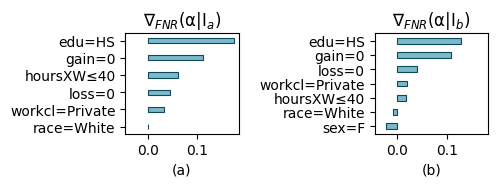

In [42]:
id_col=23

fp_divergence_ofI=fp_divergence_fnr
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" #"",""
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [43]:
id_col=23
fp_divergence_ofI=fp_divergence_fnr
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S, S_i=corrSign[["S", "S+i"]].head(id_col+1).values[id_col]
    display(fp_divergence_ofI.getInfoItemsets([S, S_i])[INFOS])
    #S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy,t_value_fp,t_value_fn,t_value_tp_tn
246,0.238313,"(race=White, capital-gain=0, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",9262.0,235.0,943.0,337.0,0.035108,0.800509,0.881229,-0.043007,0.427026,0.032549,18.055077,34.108547,9.170715
1637,0.098182,"(race=White, capital-gain=0, sex=Female, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",4132.0,77.0,146.0,85.0,0.020157,0.654709,0.947973,-0.057958,0.281225,0.099293,22.068213,8.748732,26.505231


frozenset({'race=White', 'capital-gain=0', 'sex=Female', 'workclass=Private', 'education=High School grad', 'capital-loss=0', 'hours-per-week=<=40'})


## For interactive analysis

In [44]:
selectItemsInteractive(fp_divergence_fnr)

Button(description='Select items', style=ButtonStyle())

## Accuracy

In [45]:
fp_divergence_acc=FP_Divergence(FP_fm, "d_accuracy")

In [46]:
fp_divergence_acc.getDivergence(absF=True)[ITEMSETS+DIVERGENCE_METRICS].head(10)

,support,itemsets,tn,tp,fn,fp,d_fpr,d_fnr,d_accuracy
3804,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, marital-status=Married, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
3803,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, sex=Male, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
3802,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, sex=Male, marital-status=Married, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
3799,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
4283,0.052099,"(race=White, capital-gain=0, relationship=Husband, education=High School grad, sex=Male, marital-status=Married, age=>47, capital-loss=0)",1101.0,327.0,558.0,370.0,0.173415,0.257025,-0.242568
4286,0.052099,"(race=White, capital-gain=0, relationship=Husband, education=High School grad, marital-status=Married, age=>47, capital-loss=0)",1101.0,327.0,558.0,370.0,0.173415,0.257025,-0.242568
4284,0.052099,"(race=White, capital-gain=0, relationship=Husband, education=High School grad, sex=Male, age=>47, capital-loss=0)",1101.0,327.0,558.0,370.0,0.173415,0.257025,-0.242568
4287,0.052099,"(race=White, capital-gain=0, relationship=Husband, education=High School grad, age=>47, capital-loss=0)",1101.0,327.0,558.0,370.0,0.173415,0.257025,-0.242568
3782,0.056676,"(capital-gain=0, education=High School grad, sex=Male, marital-status=Married, age=>47, capital-loss=0)",1204.0,351.0,605.0,403.0,0.172663,0.259362,-0.241969
4266,0.052231,"(race=White, capital-gain=0, education=High School grad, sex=Male, marital-status=Married, age=>47, capital-loss=0)",1107.0,327.0,558.0,370.0,0.172393,0.257025,-0.241567


### Higher Accuracy

In [47]:
d_h=fp_divergence_acc.getDivergence(absF=True)[ITEMSETS+DIVERGENCE_METRICS]
d_h=d_h.loc[d_h.d_accuracy>0]
d_h.head(5)

,support,itemsets,tn,tp,fn,fp,d_fpr,d_fnr,d_accuracy
4041,0.054067,"(hours-per-week=<=40, capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, relationship=Own-child)",2444.0,0.0,1.0,0.0,-0.078115,0.626517,0.150911
4159,0.053027,"(hours-per-week=<=40, capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, relationship=Own-child)",2397.0,0.0,1.0,0.0,-0.078115,0.626517,0.150903
1871,0.090045,"(capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, hours-per-week=<=40)",4068.0,1.0,2.0,1.0,-0.077869,0.293183,0.150583
1916,0.088231,"(capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",3987.0,0.0,2.0,1.0,-0.077864,0.626517,0.150568
4264,0.052231,"(capital-gain=0, age=<=28, marital-status=Never-Married, sex=Female, education=High School grad)",2360.0,0.0,2.0,0.0,-0.078115,0.626517,0.150473


### Lower Accuracy

In [48]:
d_lower=fp_divergence_acc.getDivergence(absF=True)[ITEMSETS+DIVERGENCE_METRICS]
d_lower=d_lower.loc[d_lower.d_accuracy<0]
d_lower.head(5)

,support,itemsets,tn,tp,fn,fp,d_fpr,d_fnr,d_accuracy
3804,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, marital-status=Married, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
3803,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, sex=Male, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
3802,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, sex=Male, marital-status=Married, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
3799,0.056499,"(capital-gain=0, relationship=Husband, education=High School grad, age=>47, capital-loss=0)",1197.0,351.0,604.0,403.0,0.173760,0.258978,-0.242809
4283,0.052099,"(race=White, capital-gain=0, relationship=Husband, education=High School grad, sex=Male, marital-status=Married, age=>47, capital-loss=0)",1101.0,327.0,558.0,370.0,0.173415,0.257025,-0.242568


### Shapley value of TOP-K patterns

Higher accuracy

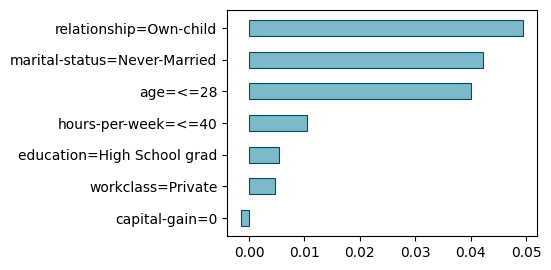

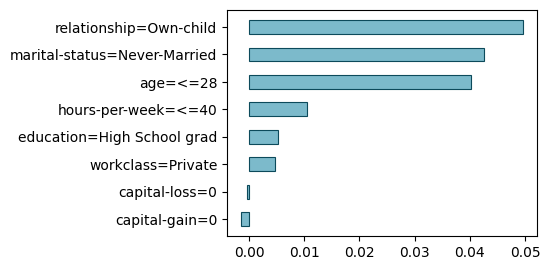

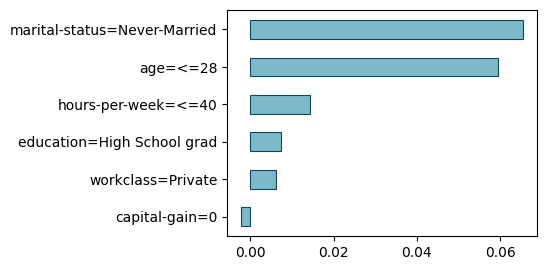

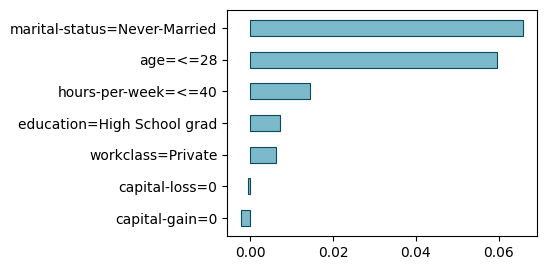

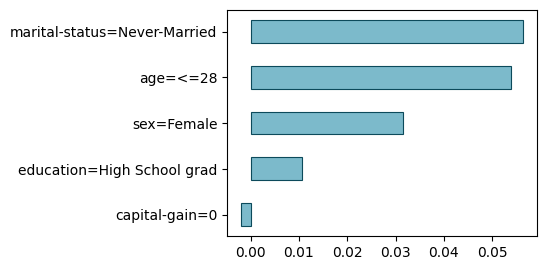

In [49]:
fp_divergence_ofI=fp_divergence_acc
d=fp_divergence_ofI.getDivergence(absF=True)[["itemsets", fp_divergence_ofI.metric]]
topK_fnr=d.loc[d[fp_divergence_ofI.metric]>0].head(5).set_index('itemsets').to_dict()[fp_divergence_ofI.metric]
for item in topK_fnr.keys():
    fp_divergence_ofI.plotShapleyValue(itemset=item)

Lower accuracy

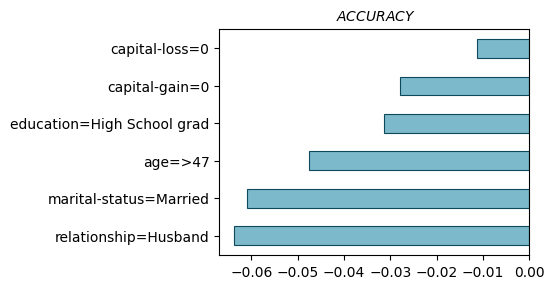

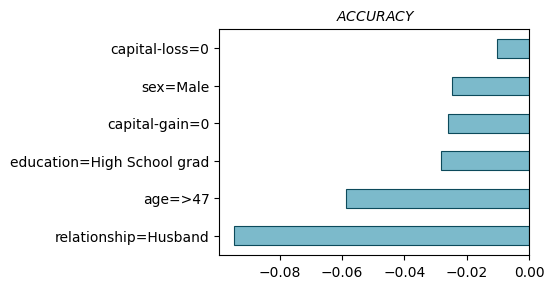

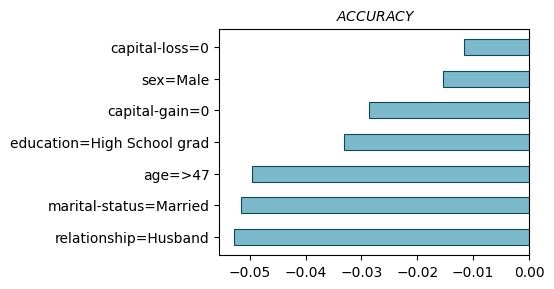

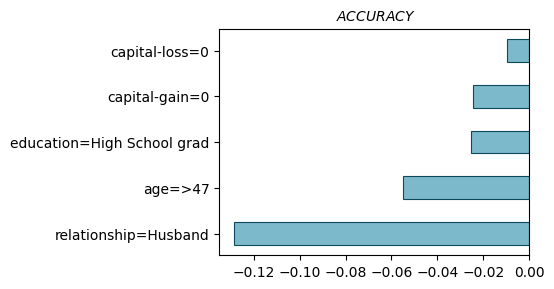

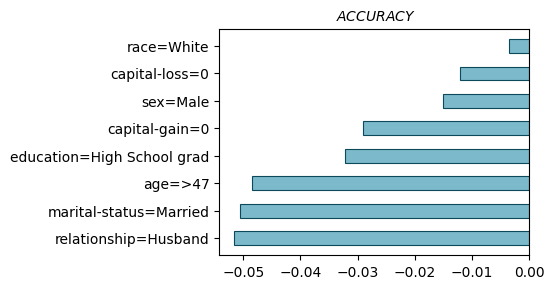

In [50]:
fp_divergence_ofI=fp_divergence_acc
d=fp_divergence_ofI.getDivergence(absF=True)[["itemsets", fp_divergence_ofI.metric]]
topK_fnr=d.loc[d[fp_divergence_ofI.metric]<0].head(5).set_index('itemsets').to_dict()[fp_divergence_ofI.metric]
for item in topK_fnr.keys():
    fp_divergence_ofI.plotShapleyValue(itemset=item, metric=fp_divergence_ofI.metric_name)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [51]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_acc.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,corr_factor
516,(education=Dropout),(marital-status=Married),"(marital-status=Married, education=Dropout)",0.096030,-0.115052,0.033146,20.168390,0.081906
2765,(relationship=Not-in-family),"(capital-gain=0, hours-per-week=>45)","(relationship=Not-in-family, capital-gain=0, hours-per-week=>45)",0.073043,-0.103237,-0.023875,8.647237,0.079362
2678,(relationship=Not-in-family),"(capital-loss=0, hours-per-week=>45)","(relationship=Not-in-family, capital-loss=0, hours-per-week=>45)",0.073043,-0.088254,-0.009372,9.108722,0.078882
2763,(relationship=Not-in-family),"(race=White, hours-per-week=>45)","(race=White, relationship=Not-in-family, hours-per-week=>45)",0.073043,-0.081144,-0.011299,7.879217,0.069845
491,(relationship=Not-in-family),(hours-per-week=>45),"(relationship=Not-in-family, hours-per-week=>45)",0.073043,-0.077435,-0.010209,8.008451,0.067226


#### Plot Shapley comparison corrective

In [52]:
fp_divergence_ofI=fp_divergence_acc
corrSign=fp_divergence_ofI.getCorrectiveItems()
id_col=0
if len(corrSign)>0:
    S,S_i=corrSign[["S", "S+i"]].values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS+[fp_divergence_ofI.t_value_col]])

,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy,t_value_tp_tn
42,0.466300,(marital-status=Married),9113.0,6357.0,3221.0,2396.0,0.208185,0.336292,0.733627,0.13007,-0.037192,-0.115052,33.068621
4320,0.051833,"(marital-status=Married, education=Dropout)",1992.0,75.0,215.0,62.0,0.030185,0.741379,0.881826,-0.04793,0.367896,0.033146,4.772057


,support,itemsets,tn,tp,fn,fp,fpr,fnr,accuracy,d_fpr,d_fnr,d_accuracy
42,0.466300,(marital-status=Married),9113.0,6357.0,3221.0,2396.0,0.208185,0.336292,0.733627,0.13007,-0.037192,-0.115052
4320,0.051833,"(marital-status=Married, education=Dropout)",1992.0,75.0,215.0,62.0,0.030185,0.741379,0.881826,-0.04793,0.367896,0.033146


∇ACCURACY(S):-0.115 -->  ∇ACCURACY(S U i):0.033


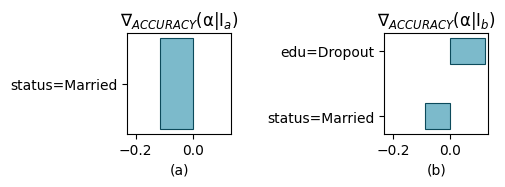

In [53]:
id_col=0
fp_divergence_ofI=fp_divergence_acc
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" #"",""
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [54]:
id_col=0
fp_divergence_ofI=fp_divergence_acc
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

frozenset({'marital-status=Married', 'education=Dropout'})


## For interactive analysis

In [55]:
selectItemsInteractive(fp_divergence_acc)

Button(description='Select items', style=ButtonStyle())

# Comparison Top FNR/FPR

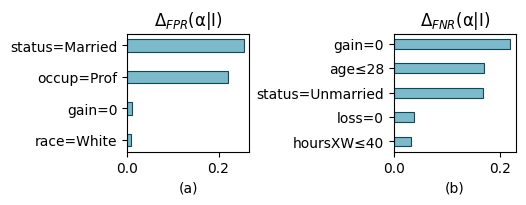

In [56]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_fpr.metric_name}_{fp_divergence_fnr.metric_name}_{min_sup}"
itemsetFP=list(fp_divergence_fpr.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
shap_itemsetFP=abbreviateDict(fp_divergence_fpr.computeShapleyValue(itemsetFP), abbreviations)

itemsetFN=list(fp_divergence_fnr.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
shap_itemsetFN=abbreviateDict(fp_divergence_fnr.computeShapleyValue(itemsetFN), abbreviations)
t1, t2=f"$Δ_{{{fp_divergence_fpr.metric_name}}}$(α|I)", f"$Δ_{{{fp_divergence_fnr.metric_name}}}$(α|I)"

plotComparisonShapleyValues(shap_itemsetFP, shap_itemsetFN, height=0.4, sharedAxis=False, \
                    sizeFig=(5.2,1.8), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=0.5, \
                            metrics_name=[fp_divergence_fpr.metric_name, fp_divergence_fnr.metric_name])

# One class

## Extract divergence

In [57]:
fp_diver_1c=FP_DivergenceExplorer(X_discretized, true_class_name="predicted", ignore_cols=["class"], class_map=class_map, dataset_name=dataset_name)
FP_fm_1c=fp_diver_1c.getFrequentPatternDivergence(min_support=min_sup, metrics=["d_posr", "d_negr"])
colsOfI_1c=["support", "itemsets", "P", "N", "posr", "d_posr", "negr", "d_negr"]
FP_fm_1c[colsOfI_1c].sort_values("negr", ascending=False).head()

,support,itemsets,P,N,posr,d_posr,negr,d_negr
4219,0.052563,"(race=White, hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, relationship=Own-child)",0.0,2377.0,0.0,-0.214033,1.0,0.214033
4264,0.052231,"(capital-gain=0, age=<=28, marital-status=Never-Married, sex=Female, education=High School grad)",0.0,2362.0,0.0,-0.214033,1.0,0.214033
4159,0.053027,"(hours-per-week=<=40, capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, relationship=Own-child)",0.0,2398.0,0.0,-0.214033,1.0,0.214033
4353,0.051568,"(race=White, hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, relationship=Own-child)",0.0,2332.0,0.0,-0.214033,1.0,0.214033
3768,0.056809,"(hours-per-week=<=40, capital-gain=0, age=<=28, workclass=Private, education=High School grad, relationship=Own-child)",0.0,2569.0,0.0,-0.214033,1.0,0.214033


## FPR

In [58]:
fp_divergence_posr=FP_Divergence(FP_fm_1c, "d_posr")

In [59]:
fp_divergence_posr.getInfoItemset(frozenset())[colsOfI_1c]

,support,itemsets,P,N,posr,d_posr,negr,d_negr
0,1.0,(),9679.0,35543.0,0.214033,0.0,0.785967,0.0


### Top FPR

In [60]:
fp_divergence_posr.getDivergence(th_redundancy=0)[colsOfI_1c].head(10)

,support,itemsets,P,N,posr,d_posr,negr,d_negr
3350,0.061674,"(race=White, occupation=Professional, marital-status=Married)",2115.0,674.0,0.758336,0.544303,0.241664,-0.544303
4422,0.050993,"(race=White, education=Bachelors, marital-status=Married, workclass=Private)",1744.0,562.0,0.756288,0.542255,0.243712,-0.542255
4237,0.052430,"(race=White, occupation=Professional, relationship=Husband)",1784.0,587.0,0.752425,0.538392,0.247575,-0.538392
4209,0.052673,"(race=White, occupation=Professional, sex=Male, marital-status=Married)",1790.0,592.0,0.751469,0.537436,0.248531,-0.537436
2865,0.068418,"(occupation=Professional, marital-status=Married)",2319.0,775.0,0.749515,0.535482,0.250485,-0.535482
3886,0.055637,"(education=Bachelors, marital-status=Married, workclass=Private)",1883.0,633.0,0.748410,0.534377,0.251590,-0.534377
3685,0.057759,"(occupation=Professional, relationship=Husband)",1946.0,666.0,0.745023,0.530990,0.254977,-0.530990
3665,0.058069,"(occupation=Professional, sex=Male, marital-status=Married)",1953.0,673.0,0.743717,0.529684,0.256283,-0.529684
3858,0.055858,"(race=White, occupation=Professional, capital-loss=0, marital-status=Married)",1869.0,657.0,0.739905,0.525872,0.260095,-0.525872
3322,0.062072,"(occupation=Professional, capital-loss=0, marital-status=Married)",2052.0,755.0,0.731030,0.516997,0.268970,-0.516997


Top FPR - Only divergence info

In [61]:
fp_divergence_posr.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_posr.metric, fp_divergence_posr.t_value_col]].head(5)

,support,itemsets,d_posr,t_value_tp_fn
3350,0.061674,"(race=White, occupation=Professional, marital-status=Married)",0.544303,65.317115
4422,0.050993,"(race=White, education=Bachelors, marital-status=Married, workclass=Private)",0.542255,59.282562
4237,0.052430,"(race=White, occupation=Professional, relationship=Husband)",0.538392,59.346520
4209,0.052673,"(race=White, occupation=Professional, sex=Male, marital-status=Married)",0.537436,59.299296
2865,0.068418,"(occupation=Professional, marital-status=Married)",0.535482,66.722790


Formatted

Threshold on redundancy

In [62]:
div_posr=fp_divergence_posr.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_posr.metric, fp_divergence_posr.t_value_col]]
print(f"{dataset_name} - #FP: {len(div_posr)-1} - {fp_divergence_posr.metric_name}")
display(div_posr.head())

adult - #FP: 3838 - POSR


,support,itemsets,d_posr,t_value_tp_fn
3350,0.061674,"(race=White, occupation=Professional, marital-status=Married)",0.544303,65.317115
4422,0.050993,"(race=White, education=Bachelors, marital-status=Married, workclass=Private)",0.542255,59.282562
4237,0.052430,"(race=White, occupation=Professional, relationship=Husband)",0.538392,59.346520
4209,0.052673,"(race=White, occupation=Professional, sex=Male, marital-status=Married)",0.537436,59.299296
2865,0.068418,"(occupation=Professional, marital-status=Married)",0.535482,66.722790


In [63]:
th_redundancy=0.05
div_posr=fp_divergence_posr.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_posr.metric, fp_divergence_posr.t_value_col]]
print(f"{dataset_name} - #FP: {len(div_posr)-1} - {fp_divergence_posr.metric_name} - th_redundancy: {th_redundancy}")
display(div_posr.head())

adult - #FP: 106 - POSR - th_redundancy: 0.05


,support,itemsets,d_posr,t_value_tp_fn
2865,0.068418,"(occupation=Professional, marital-status=Married)",0.535482,66.722790
3685,0.057759,"(occupation=Professional, relationship=Husband)",0.530990,60.726636
2432,0.076312,"(education=Bachelors, relationship=Husband)",0.512423,65.446149
1970,0.086418,"(education=Bachelors, marital-status=Married)",0.509355,68.729473
2732,0.070231,"(occupation=White-Collar, relationship=Husband)",0.500073,60.643129


### Shapley value of TOP-K patterns

In [64]:
fp_divergence_ofI=fp_divergence_posr
topK_fpr=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
topK_fpr

{frozenset({'marital-status=Married',
            'occupation=Professional',
            'race=White'}): 0.5443033284709817,
 frozenset({'education=Bachelors',
            'marital-status=Married',
            'race=White',
            'workclass=Private'}): 0.5422549517015085,
 frozenset({'occupation=Professional',
            'race=White',
            'relationship=Husband'}): 0.5383921442818456,
 frozenset({'marital-status=Married',
            'occupation=Professional',
            'race=White',
            'sex=Male'}): 0.5374363606933474,
 frozenset({'marital-status=Married',
            'occupation=Professional'}): 0.535482197900542}

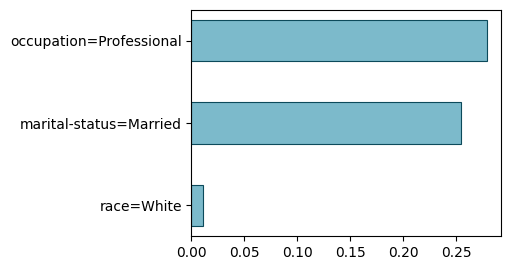

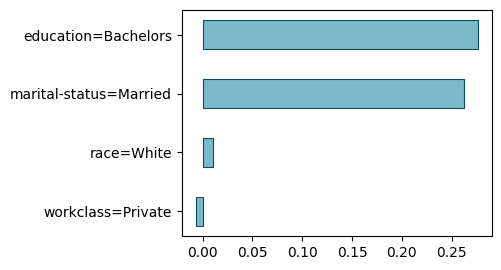

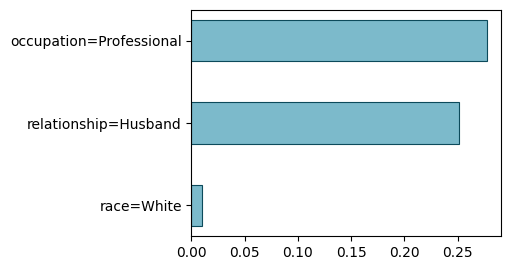

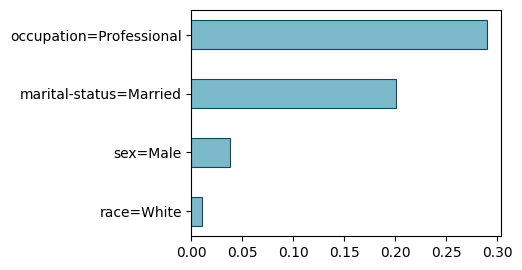

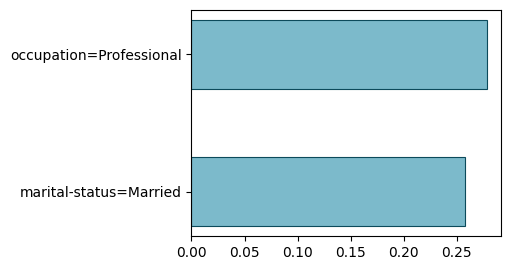

In [65]:
fp_divergence_ofI=fp_divergence_posr
topK_fpr=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_fpr.keys():
    fp_divergence_ofI.plotShapleyValue(itemset=item)

{frozenset({'race=White', 'occupation=Professional', 'marital-status=Married'}): 0.5443033284709817}


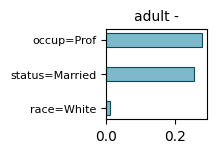

In [66]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_posr.metric_name}_{min_sup}"
itemset_div=fp_divergence_posr.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_posr.computeShapleyValue(list(itemset_div.keys())[0])
fp_divergence_posr.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=False, nameFig=outputName)

#### Lattice Explorer

In [67]:
top1=list(fp_divergence_posr.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_posr.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small", getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [68]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_posr.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,corr_factor
2735,(occupation=Blue-Collar),"(marital-status=Married, age=(37-47])","(occupation=Blue-Collar, marital-status=Married, age=(37-47])",-0.110136,0.299139,0.009657,27.279736,0.289482
7794,(occupation=Blue-Collar),"(sex=Male, marital-status=Married, age=(37-47])","(sex=Male, occupation=Blue-Collar, marital-status=Married, age=(37-47])",-0.110136,0.294479,0.009315,26.082057,0.285164
7675,(occupation=Blue-Collar),"(race=White, age=>47, marital-status=Married)","(race=White, age=>47, occupation=Blue-Collar, marital-status=Married)",-0.110136,0.247456,0.013788,21.737893,0.233669
7775,(occupation=Blue-Collar),"(race=White, age=>47, relationship=Husband)","(race=White, age=>47, occupation=Blue-Collar, relationship=Husband)",-0.110136,0.246976,0.014538,21.179121,0.232437
13843,(occupation=Blue-Collar),"(race=White, age=>47, marital-status=Married, relationship=Husband)","(race=White, relationship=Husband, occupation=Blue-Collar, marital-status=Married, age=>47)",-0.110136,0.246976,0.014538,21.179121,0.232437


Details of $S$ and $S \cup i$ for the top corrective items

In [69]:
d=fp_divergence_posr.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_posr.getInfoItemsets([S,S_i])[colsOfI_1c])

,support,itemsets,P,N,posr,d_posr,negr,d_negr
761,0.143536,"(marital-status=Married, age=(37-47])",3331.0,3160.0,0.513172,0.299139,0.486828,-0.299139
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",525.0,1822.0,0.223690,0.009657,0.776310,-0.009657


,support,itemsets,P,N,posr,d_posr,negr,d_negr
943,0.128588,"(sex=Male, marital-status=Married, age=(37-47])",2957.0,2858.0,0.508512,0.294479,0.491488,-0.294479
4513,0.050197,"(sex=Male, occupation=Blue-Collar, marital-status=Married, age=(37-47])",507.0,1763.0,0.223348,0.009315,0.776652,-0.009315


,support,itemsets,P,N,posr,d_posr,negr,d_negr
815,0.138671,"(race=White, age=>47, marital-status=Married)",2894.0,3377.0,0.461489,0.247456,0.538511,-0.247456
4375,0.051347,"(race=White, age=>47, occupation=Blue-Collar, marital-status=Married)",529.0,1793.0,0.227821,0.013788,0.772179,-0.013788


,support,itemsets,P,N,posr,d_posr,negr,d_negr
946,0.128455,"(race=White, age=>47, relationship=Husband)",2678.0,3131.0,0.461009,0.246976,0.538991,-0.246976
4496,0.050307,"(race=White, age=>47, occupation=Blue-Collar, relationship=Husband)",520.0,1755.0,0.228571,0.014538,0.771429,-0.014538


#### Plot Shapley comparison corrective

,support,itemsets,P,N,posr,d_posr,negr,d_negr
761,0.143536,"(marital-status=Married, age=(37-47])",3331.0,3160.0,0.513172,0.299139,0.486828,-0.299139
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",525.0,1822.0,0.223690,0.009657,0.776310,-0.009657


∇POSR(S):0.299 -->  ∇POSR(S U i):0.01


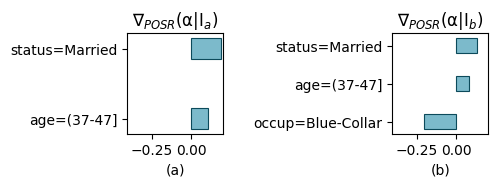

In [70]:
id_col=0
fp_divergence_ofI=fp_divergence_posr
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[colsOfI_1c])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" 
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=False, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [71]:
id_col=0
fp_divergence_ofI=fp_divergence_posr
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

frozenset({'occupation=Blue-Collar', 'marital-status=Married', 'age=(37-47]'})


## For interactive analysis

In [72]:
selectItemsInteractive(fp_divergence_posr)

Button(description='Select items', style=ButtonStyle())

## FNR

In [73]:
fp_divergence_negr=FP_Divergence(FP_fm_1c, "d_negr")

### Top Neg RATE

In [74]:
fp_divergence_negr.getDivergence(th_redundancy=0)[colsOfI_1c].head(10)

,support,itemsets,P,N,posr,d_posr,negr,d_negr
3283,0.062691,"(hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, relationship=Own-child)",0.0,2835.0,0.000000,-0.214033,1.000000,0.214033
3768,0.056809,"(hours-per-week=<=40, capital-gain=0, age=<=28, workclass=Private, education=High School grad, relationship=Own-child)",0.0,2569.0,0.000000,-0.214033,1.000000,0.214033
4264,0.052231,"(capital-gain=0, age=<=28, marital-status=Never-Married, sex=Female, education=High School grad)",0.0,2362.0,0.000000,-0.214033,1.000000,0.214033
1916,0.088231,"(capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",1.0,3989.0,0.000251,-0.213782,0.999749,0.213782
2554,0.073371,"(race=White, capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",1.0,3317.0,0.000301,-0.213732,0.999699,0.213732
2626,0.072111,"(hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, education=High School grad, relationship=Own-child)",1.0,3260.0,0.000307,-0.213726,0.999693,0.213726
2709,0.070629,"(hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, education=High School grad, capital-loss=0, relationship=Own-child)",1.0,3193.0,0.000313,-0.213720,0.999687,0.213720
2872,0.068330,"(capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, relationship=Own-child)",1.0,3089.0,0.000324,-0.213709,0.999676,0.213709
2957,0.066936,"(capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, relationship=Own-child)",1.0,3026.0,0.000330,-0.213703,0.999670,0.213703
3134,0.064570,"(relationship=Own-child, capital-gain=0, age=<=28, education=High School grad, hours-per-week=<=40)",1.0,2919.0,0.000342,-0.213691,0.999658,0.213691


Top FPR - Only divergence info

In [75]:
div_negr=fp_divergence_negr.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_negr.metric, fp_divergence_negr.t_value_col]]
div_negr.head(10)

,support,itemsets,d_negr,t_value_tn_fp
3283,0.062691,"(hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, relationship=Own-child)",0.214033,108.992999
3768,0.056809,"(hours-per-week=<=40, capital-gain=0, age=<=28, workclass=Private, education=High School grad, relationship=Own-child)",0.214033,108.593559
4264,0.052231,"(capital-gain=0, age=<=28, marital-status=Never-Married, sex=Female, education=High School grad)",0.214033,108.190955
1916,0.088231,"(capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",0.213782,108.899557
2554,0.073371,"(race=White, capital-gain=0, age=<=28, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, hours-per-week=<=40)",0.213732,108.065495
2626,0.072111,"(hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, education=High School grad, relationship=Own-child)",0.213726,107.971831
2709,0.070629,"(hours-per-week=<=40, capital-gain=0, marital-status=Never-Married, education=High School grad, capital-loss=0, relationship=Own-child)",0.213720,107.855706
2872,0.068330,"(capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, relationship=Own-child)",0.213709,107.661357
2957,0.066936,"(capital-gain=0, marital-status=Never-Married, workclass=Private, education=High School grad, capital-loss=0, relationship=Own-child)",0.213703,107.534485
3134,0.064570,"(relationship=Own-child, capital-gain=0, age=<=28, education=High School grad, hours-per-week=<=40)",0.213691,107.301356


Threshold on redundancy

In [76]:
th_redundancy=0.05
div_negr=fp_divergence_negr.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_negr.metric, fp_divergence_negr.t_value_col]]
display(div_negr.head(5))
print(f"{dataset_name} - #FP {len(div_negr)-1} - {fp_divergence_negr.metric_name} - th_redundancy: {th_redundancy}")

,support,itemsets,d_negr,t_value_tn_fp
721,0.146522,(relationship=Own-child),0.206185,92.927486
1277,0.111450,(occupation=Service),0.192803,68.635907
180,0.262881,(age=<=28),0.187199,76.896126
123,0.322807,(marital-status=Never-Married),0.186906,79.447348
1010,0.125182,(education=Dropout),0.186299,63.816020


adult - #FP 106 - NEGR - th_redundancy: 0.05


### Shapley value of TOP-K patterns

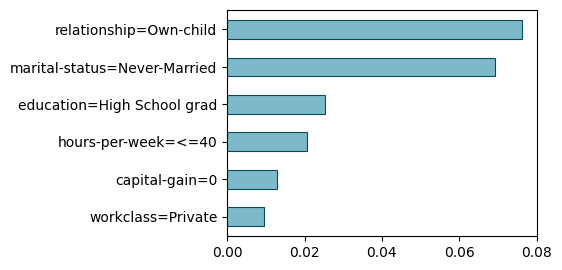

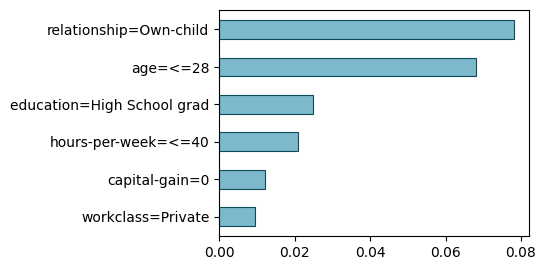

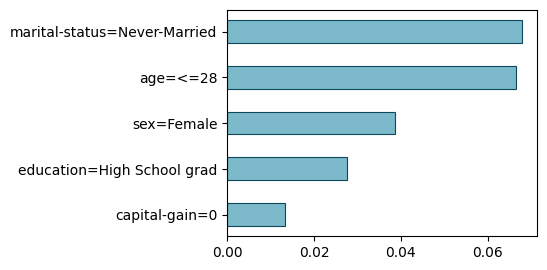

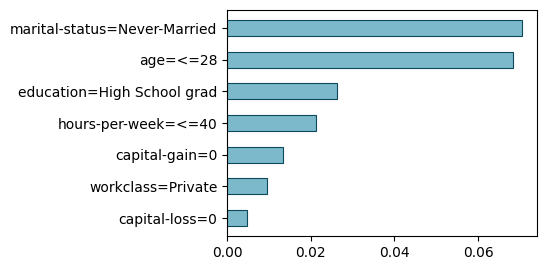

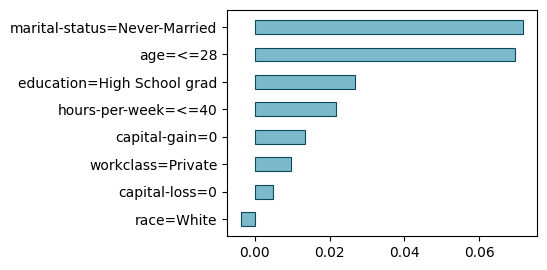

In [77]:
fp_divergence_ofI=fp_divergence_negr
topK_negr=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_negr.keys():
    fp_divergence_ofI.plotShapleyValue(itemset=item)

{frozenset({'hours-per-week=<=40', 'capital-gain=0', 'marital-status=Never-Married', 'workclass=Private', 'education=High School grad', 'relationship=Own-child'}): 0.21403299279111931}


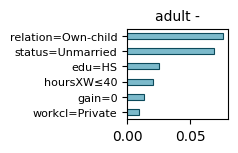

In [78]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_negr.metric_name}_{min_sup}"
itemset_div=fp_divergence_negr.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_negr.computeShapleyValue(list(itemset_div.keys())[0])
fp_divergence_negr.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=saveFig, nameFig=outputName)

#### Lattice Explorer

In [79]:
top1=list(fp_divergence_negr.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_negr.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small")#, getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [80]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_negr.getCorrectiveItems()
corrSign.head(10)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,corr_factor
2735,(occupation=Blue-Collar),"(marital-status=Married, age=(37-47])","(occupation=Blue-Collar, marital-status=Married, age=(37-47])",0.110136,-0.299139,-0.009657,27.279736,0.289482
7794,(occupation=Blue-Collar),"(sex=Male, marital-status=Married, age=(37-47])","(sex=Male, occupation=Blue-Collar, marital-status=Married, age=(37-47])",0.110136,-0.294479,-0.009315,26.082057,0.285164
7675,(occupation=Blue-Collar),"(race=White, age=>47, marital-status=Married)","(race=White, age=>47, occupation=Blue-Collar, marital-status=Married)",0.110136,-0.247456,-0.013788,21.737893,0.233669
7775,(occupation=Blue-Collar),"(race=White, age=>47, relationship=Husband)","(race=White, age=>47, occupation=Blue-Collar, relationship=Husband)",0.110136,-0.246976,-0.014538,21.179121,0.232437
13843,(occupation=Blue-Collar),"(race=White, age=>47, marital-status=Married, relationship=Husband)","(race=White, relationship=Husband, occupation=Blue-Collar, marital-status=Married, age=>47)",0.110136,-0.246976,-0.014538,21.179121,0.232437
13849,(occupation=Blue-Collar),"(race=White, age=>47, sex=Male, relationship=Husband)","(race=White, relationship=Husband, sex=Male, occupation=Blue-Collar, age=>47)",0.110136,-0.246976,-0.014538,21.179121,0.232437
18133,(occupation=Blue-Collar),"(race=White, relationship=Husband, sex=Male, marital-status=Married, age=>47)","(race=White, relationship=Husband, sex=Male, occupation=Blue-Collar, marital-status=Married, age=>47)",0.110136,-0.246976,-0.014538,21.179121,0.232437
13833,(occupation=Blue-Collar),"(race=White, age=>47, sex=Male, marital-status=Married)","(race=White, sex=Male, occupation=Blue-Collar, marital-status=Married, age=>47)",0.110136,-0.245946,-0.013937,21.180302,0.232009
12963,(occupation=Blue-Collar),"(age=>47, sex=Male, marital-status=Married, relationship=Husband)","(relationship=Husband, sex=Male, occupation=Blue-Collar, marital-status=Married, age=>47)",0.110136,-0.241903,-0.014379,21.755134,0.227523
7167,(occupation=Blue-Collar),"(age=>47, sex=Male, relationship=Husband)","(age=>47, sex=Male, occupation=Blue-Collar, relationship=Husband)",0.110136,-0.241903,-0.014379,21.755134,0.227523


Details of $S$ and $S \cup i$ for the top corrective items

In [81]:
d=fp_divergence_negr.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_negr.getInfoItemsets([S,S_i])[colsOfI_1c])

,support,itemsets,P,N,posr,d_posr,negr,d_negr
761,0.143536,"(marital-status=Married, age=(37-47])",3331.0,3160.0,0.513172,0.299139,0.486828,-0.299139
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",525.0,1822.0,0.223690,0.009657,0.776310,-0.009657


,support,itemsets,P,N,posr,d_posr,negr,d_negr
943,0.128588,"(sex=Male, marital-status=Married, age=(37-47])",2957.0,2858.0,0.508512,0.294479,0.491488,-0.294479
4513,0.050197,"(sex=Male, occupation=Blue-Collar, marital-status=Married, age=(37-47])",507.0,1763.0,0.223348,0.009315,0.776652,-0.009315


,support,itemsets,P,N,posr,d_posr,negr,d_negr
815,0.138671,"(race=White, age=>47, marital-status=Married)",2894.0,3377.0,0.461489,0.247456,0.538511,-0.247456
4375,0.051347,"(race=White, age=>47, occupation=Blue-Collar, marital-status=Married)",529.0,1793.0,0.227821,0.013788,0.772179,-0.013788


,support,itemsets,P,N,posr,d_posr,negr,d_negr
946,0.128455,"(race=White, age=>47, relationship=Husband)",2678.0,3131.0,0.461009,0.246976,0.538991,-0.246976
4496,0.050307,"(race=White, age=>47, occupation=Blue-Collar, relationship=Husband)",520.0,1755.0,0.228571,0.014538,0.771429,-0.014538


#### Plot Shapley comparison corrective

In [82]:
fp_divergence_ofI=fp_divergence_negr
corrSign=fp_divergence_ofI.getCorrectiveItems()
id_col=0
if len(corrSign)>0:
    S,S_i=corrSign[["S", "S+i"]].values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[colsOfI_1c])

,support,itemsets,P,N,posr,d_posr,negr,d_negr
761,0.143536,"(marital-status=Married, age=(37-47])",3331.0,3160.0,0.513172,0.299139,0.486828,-0.299139
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",525.0,1822.0,0.223690,0.009657,0.776310,-0.009657


,support,itemsets,P,N,posr,d_posr,negr,d_negr
761,0.143536,"(marital-status=Married, age=(37-47])",3331.0,3160.0,0.513172,0.299139,0.486828,-0.299139
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",525.0,1822.0,0.223690,0.009657,0.776310,-0.009657


∇NEGR(S):-0.299 -->  ∇NEGR(S U i):-0.01


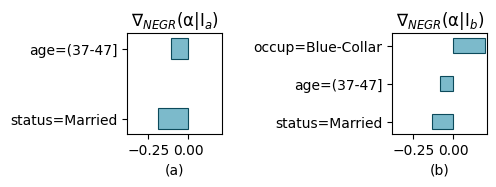

In [83]:
id_col=0

fp_divergence_ofI=fp_divergence_negr
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[colsOfI_1c])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" #"",""
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [84]:
id_col=0
fp_divergence_ofI=fp_divergence_negr
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S, S_i=corrSign[["S", "S+i"]].head(id_col+1).values[id_col]
    display(fp_divergence_ofI.getInfoItemsets([S, S_i])[colsOfI_1c])
    #S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

,support,itemsets,P,N,posr,d_posr,negr,d_negr
761,0.143536,"(marital-status=Married, age=(37-47])",3331.0,3160.0,0.513172,0.299139,0.486828,-0.299139
4310,0.051900,"(occupation=Blue-Collar, marital-status=Married, age=(37-47])",525.0,1822.0,0.223690,0.009657,0.776310,-0.009657


frozenset({'occupation=Blue-Collar', 'marital-status=Married', 'age=(37-47]'})


## For interactive analysis

In [85]:
selectItemsInteractive(fp_divergence_negr)

Button(description='Select items', style=ButtonStyle())

# Global

In [86]:
saveFig=False
outDirGlobal="./results/figures/global"
if saveFig:
    createDir(outDirGlobal)

## FNR

In [87]:
u_h_fnr=fp_divergence_fnr.computeGlobalShapleyValue()

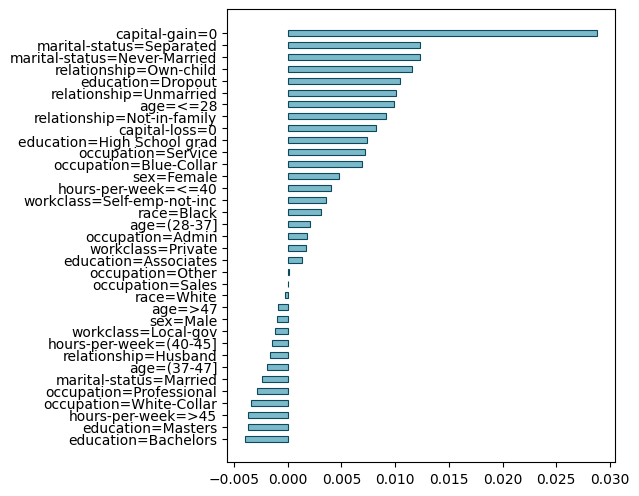

In [88]:
fp_divergence_fnr.plotShapleyValue(shapley_values=u_h_fnr, sizeFig=(5,6))

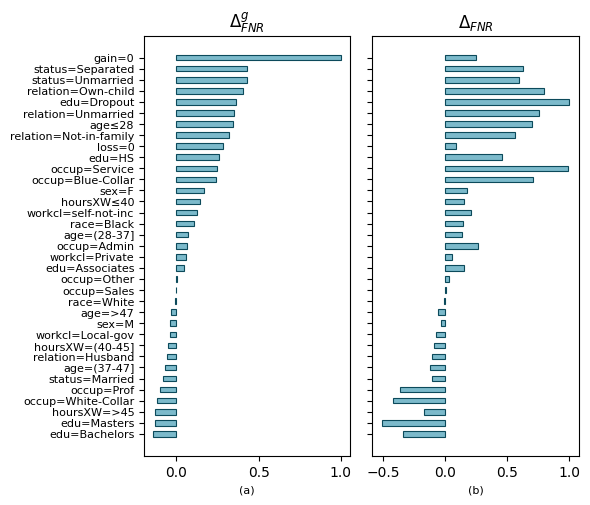

In [89]:
compareShapleyValues(normalizeMax(abbreviateDict(u_h_fnr, abbreviations)), 
                     normalizeMax(abbreviateDict(fp_divergence_fnr.getFItemsetsDivergence()[1], abbreviations)) , \
                     title=["$\Delta^g_{FNR}$", "$\Delta_{FNR}$"], \
                      labelsize=8, height=0.5, sizeFig=(6,5), \
                     saveFig=saveFig, subcaption=True,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_FNR_shap_gl_compare_{min_sup}")

## FPR

In [90]:
u_h_fpr=fp_divergence_fpr.computeGlobalShapleyValue()

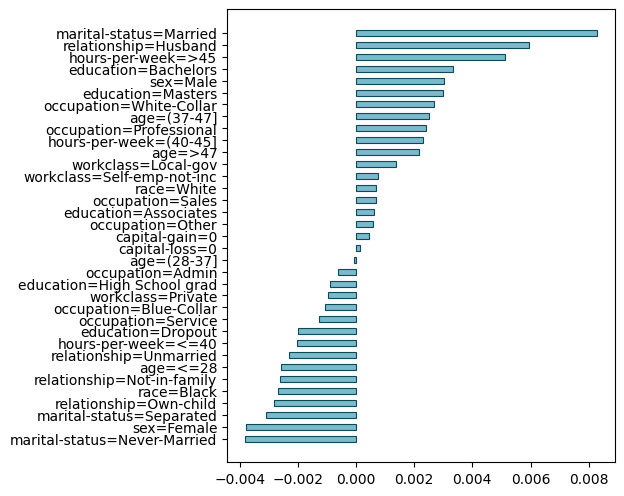

In [91]:
fp_divergence_fpr.plotShapleyValue(shapley_values=u_h_fpr,sizeFig=(5,6))

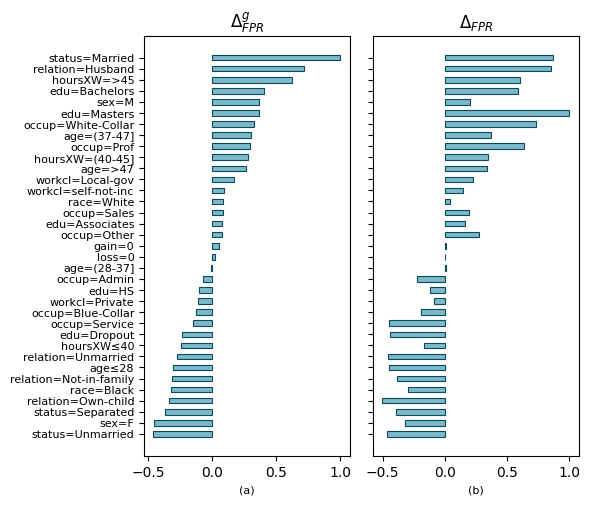

In [92]:
compareShapleyValues(normalizeMax(abbreviateDict(u_h_fpr, abbreviations)),\
                     normalizeMax(abbreviateDict(fp_divergence_fpr.getFItemsetsDivergence()[1], abbreviations)), \
                     title=["$\Delta^g_{FPR}$", "$\Delta_{FPR}$"], \
                      labelsize=8, height=0.5, sizeFig=(6,5),\
                     saveFig=saveFig, subcaption=True,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_FPR_shap_gl_compare_{min_sup}")

## Accuracy

In [93]:
u_h_acc=fp_divergence_acc.computeGlobalShapleyValue()

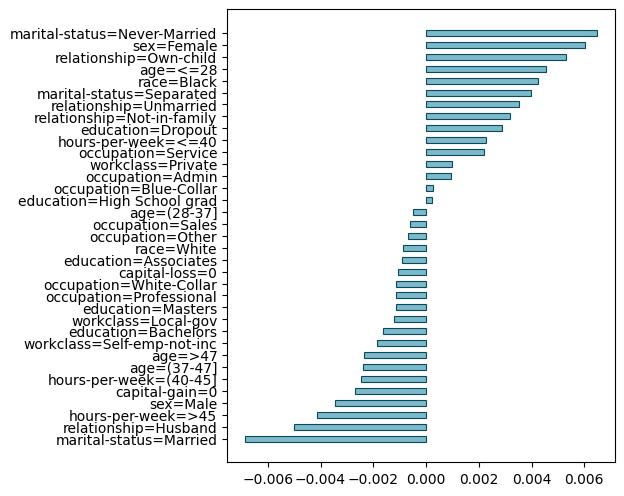

In [94]:
fp_divergence_acc.plotShapleyValue(shapley_values=u_h_acc,  sizeFig=(5,6))

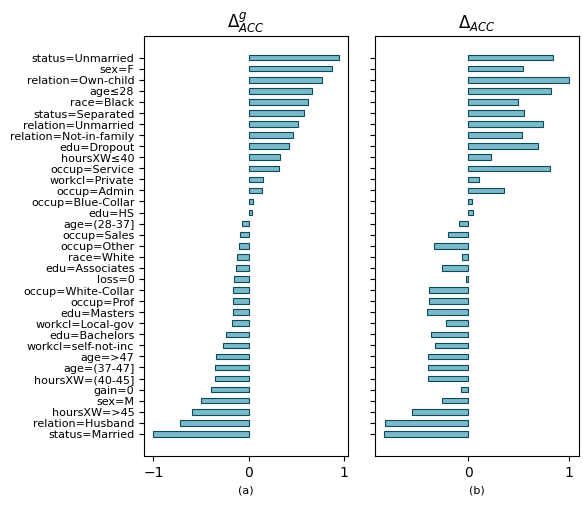

In [95]:
compareShapleyValues(normalizeMax(abbreviateDict(u_h_acc, abbreviations)),\
                     normalizeMax(abbreviateDict(fp_divergence_acc.getFItemsetsDivergence()[1], abbreviations)), \
                     title=["$\Delta^g_{ACC}$", "$\Delta_{ACC}$"], \
                      labelsize=8, height=0.5, sizeFig=(6,5),\
                     saveFig=saveFig, subcaption=True,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_ACC_shap_gl_compare_{min_sup}")

## Compare FPR,FNR

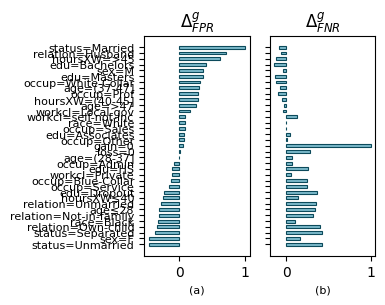

In [96]:
compareShapleyValues(normalizeMax(abbreviateDict(u_h_fpr, abbreviations)), normalizeMax(abbreviateDict(u_h_fnr, abbreviations)), \
                     title=[f"$\Delta^g_{{{fp_divergence_fpr.metric_name}}}$", f"$\Delta^g_{{{fp_divergence_fnr.metric_name}}}$"], \
                      labelsize=8, height=0.5, sizeFig=(4,3), \
                     saveFig=saveFig, subcaption=True,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_FPR_FNR_shap_gl_compare_{min_sup}")

## Top K Global plot

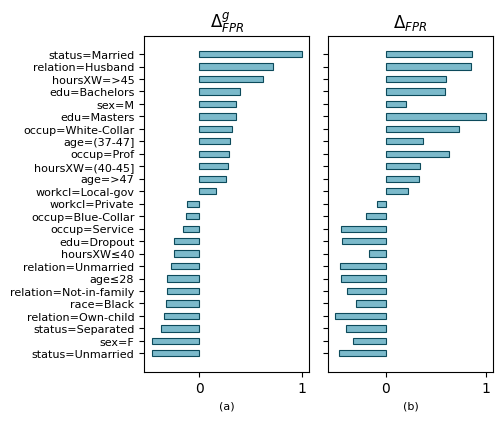

In [97]:
K=25
topK_global={k:v for k,v in u_h_fpr.items() if k in sorted(u_h_fpr, key=lambda x: abs(u_h_fpr[x]))[::-1][:K]}
topK_I_len1={k:v for k,v in fp_divergence_fpr.getFItemsetsDivergence()[1].items() if k in topK_global.keys()}

compareShapleyValues(normalizeMax(abbreviateDict(topK_global, abbreviations)),\
                     normalizeMax(abbreviateDict(topK_I_len1, abbreviations)), \
                     title=["$\Delta^g_{FPR}$", "$\Delta_{FPR}$"], \
                      labelsize=8, height=0.5, sizeFig=(5,4),\
                     saveFig=saveFig, subcaption=True,\
                     pad=0.5,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_FPR_shap_gl_compare_{min_sup}_top{K}")

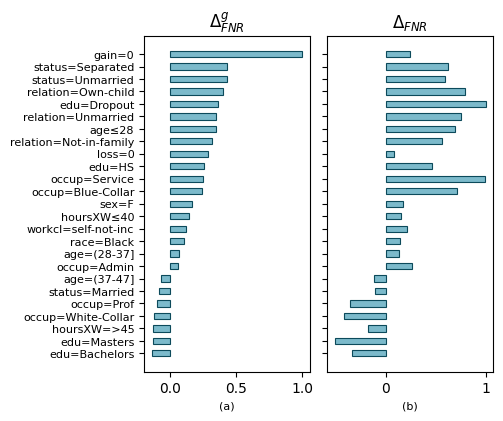

In [98]:
K=25
topK_global={k:v for k,v in u_h_fnr.items() if k in sorted(u_h_fnr, key=lambda x: abs(u_h_fnr[x]))[::-1][:K]}
topK_I_len1={k:v for k,v in fp_divergence_fnr.getFItemsetsDivergence()[1].items() if k in topK_global.keys()}
compareShapleyValues(normalizeMax(abbreviateDict(topK_global, abbreviations)),\
                     normalizeMax(abbreviateDict(topK_I_len1, abbreviations)), \
                     title=["$\Delta^g_{FNR}$", "$\Delta_{FNR}$"], \
                      labelsize=8, height=0.5, sizeFig=(5,4),\
                     saveFig=saveFig, subcaption=True,\
                     pad=0.5,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_FNR_shap_gl_compare_{min_sup}_top{K}")